# Drive Operations

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%pwd
%cd 'drive/My Drive/Workspaces/twitter_sentiment_analysis'

/content/drive/My Drive/Workspaces/twitter_sentiment_analysis


# Libraries

In [3]:
! pip install transformers

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 890kB 16.1MB/s 
     |████████████████████████████████| 1.1MB 20.7MB/s 
     |████████████████████████████████| 2.9MB 30.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=94192b9a835a69de9a86a8585d4cb07bcc0e6c749a21c66f9067a00627d5cb35
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [5]:
! pip install contractions

     |████████████████████████████████| 317kB 3.8MB/s 
     |████████████████████████████████| 245kB 8.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81698 sha256=d8819a716837a22a9df0c87ba7c1a47d3b75e0edd552c4bf1539adca6891b8b6
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [6]:
import contractions
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA and Cleaning
1. Importing data
2. Exploring data
3. Cleaning data
4. Saving data

## Import data

In [7]:
import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [8]:
train_df['tweet'] = train_df['tweet'].str.replace('@user','')
test_df['tweet'] = test_df['tweet'].str.replace('@user','')

## Target distribution

In [9]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

There is a target imbalance in the data.
Need to be handled later on.

In [10]:
train_df.tweet.isnull().any()

False

There is no missing data present

### Since it is twitter data. Hashtags are important.
Get the hashtags and analyse the effect.

In [11]:
train_df['hashtags'] = train_df.tweet.apply(lambda tweet: ','.join([word[1:] for word in tweet.split() if '#' == word[0]]))
test_df['hashtags'] = test_df.tweet.apply(lambda tweet: ','.join([word[1:] for word in tweet.split() if '#' == word[0]]))

In [12]:
no_hashtags = train_df[train_df.hashtags == ''].hashtags.count()
hashtags = train_df[~(train_df.hashtags == '')].hashtags.count()
print('{}% of tweets have hashtags.'.format(round(100*(hashtags/(hashtags + no_hashtags)),2)))

72.98% of tweets have hashtags.


In [13]:
train_df[train_df.hashtags == ''].label.value_counts()

0    8024
1     613
Name: label, dtype: int64

In [14]:
train_df[~(train_df.hashtags == '')].hashtags.count()

23325

## Data Cleaning

In [15]:
def clean_text(df):
  # Copying twitter data
  df['cleaned_tweet'] = df['tweet']
  # Remove URLs
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : ' '.join([word for word in tweet.split() if not 'www' in word and not '.co' in word]))
  # Expand contractions
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tweet: contractions.fix(tweet).lower())
  # Remove stop words
  stop_words = set(stopwords.words('english')) 
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tweet: ' '.join([word for word in tweet.split() if not word in stop_words]))
  # Remove junk characters - encode and decode
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : tweet.encode('ascii','ignore').decode('ascii'))
  # Remove punctuations
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : re.sub(r'[^\w\s]','',tweet))

  return df


In [16]:
train_df = clean_text(train_df)
test_df = clean_text(test_df)

In [17]:
train_df.head()

,id,label,tweet,hashtags,cleaned_tweet
0,1,0,when a father is dysfunctional and is so sel...,run,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks for #lyft credit i can't use cause th...,"lyft,disapointed,getthanked",thanks lyft credit use offer wheelchair vans p...
2,3,0,bihday your majesty,,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model,model love take time ur
4,5,0,factsguide: society now #motivation,motivation,factsguide society motivation


## Arranging input for BERT

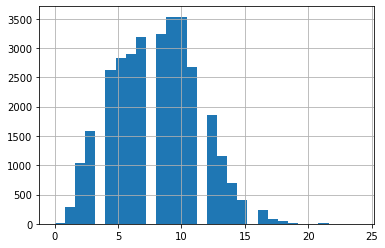

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df.cleaned_tweet]

pd.Series(seq_len).hist(bins = 30)

Keeping the padding length as 24.


In [19]:
# Splitting the data train and temp sets
train_X, temp_X, train_y, temp_y = train_test_split(train_df['cleaned_tweet'], train_df['label'],
                                                    test_size = 0.3,
                                                    stratify=train_df['label'])

# Splitting temp further to validation and test sets 
val_X, test_X, val_y, test_y = train_test_split(train_df['cleaned_tweet'], train_df['label'],
                                                    test_size = 0.3,
                                                    stratify=train_df['label'])

In [20]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [21]:
# Tokenization

tokens_train = tokenizer.batch_encode_plus(train_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

tokens_val = tokenizer.batch_encode_plus(val_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

tokens_test = tokenizer.batch_encode_plus(test_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

In [22]:
# Convert to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_labels = torch.tensor(train_y.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_labels = torch.tensor(val_y.tolist())


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_labels = torch.tensor(test_y.tolist())


In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

# BERT
1. Define Architecture and forward pass

In [24]:
# importing the pre-trained model
bert = transformers.AutoModel.from_pretrained('bert-base-uncased')

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

CLASStorch.nn.Module[SOURCE]
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

```
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

```



In [25]:
class BERT_Arch(nn.Module):

  
  def __init__(self,bert):
    '''
    Define the layer architecture
    BERT | FC1:ReLU | FC2(Output):Softmax
    '''
    # initialize the NN module
    super().__init__()

    self.bert = bert

    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(768,512)
    
    self.fc2 = nn.Linear(512,2)

    self.softmax = nn.LogSoftmax(dim = 1)

  
  def forward(self, input_ids, attention_mask):
    '''
    Forward pass of the inputs in the network defined
    Return the output
    '''

    _, bert_layer_output = self.bert(input_ids, attention_mask = attention_mask)

    x = self.fc1(bert_layer_output)
    x = self.relu(x)

    x = self.dropout(x)

    x = self.fc2(x)
    x = self.softmax(x)

    return x


2. Add the peripherals:-
  * Optimizer
  * Loss function
  * Metrics

In [27]:
# Initializing the object of the NN class by passing the pre-trained model
model = BERT_Arch(bert)

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)


We have a class imbalance, so we will have to compute the weights accordingly

In [32]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(train_y), train_y)
print('Class weights:', class_weights)

# Converting weights to a tensor
weights = torch.tensor(class_weights,dtype=torch.float)

cross_entropy = nn.NLLLoss(weight = weights)
epochs = 10

Class weights: [0.53770909 7.12970045]


## Fine Tune (Train) BERT

Batch 50 of 700.


In [42]:
# Function to Train the model

def train():
  total_loss = 0
  total_accuracy = 0
  total_preds = []

  model.train()

  for step, batch in enumerate(train_dataloader):

    if step != 0 and step % 50  == 0:
      print('Batch {} of {}.'.format(step, len(train_dataloader)))

    input_ids, mask, labels = batch

    # Make the learnt gradients zero
    model.zero_grad()

    pred = model(input_ids, mask)

    loss = cross_entropy(pred,labels)

    total_loss += loss.item()

    loss.backward()
    
    # clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    total_preds.append(pred)

  avg_loss = total_loss/len(train_dataloader)

  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds



In [39]:
def evaluate():

  # deactivate the dropout layers
  model.eval()

  total_loss = 0
  total_accuracy = 0
  total_preds = []

  for step, batch in enumerate(val_dataloader):

    if step != 0 and step % 50 == 0:
      # Print progress
      elasped = format_time(time.time() - t0)
      print('Batch {} of {}.'.format(step, len(val_dataloader)))

    input_ids, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      pred = model(input_ids, mask)
      loss = cross_entropy(pred, labels)
      total_loss += loss.item()
      total_preds.append(pred)

    avg_loss = total_loss/len(val_dataloader)

  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
  
  return avg_loss, total_preds
    

In [43]:
# set initial loss to infinite

lowest_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
  print('Epoch: {}/{}'.format(epoch + 1, epochs))

  train_loss,_ = train()

  val_loss,_ = evaluate()

  # save the best model
  if val_loss < lowest_valid_loss:
    val_loss = lowest_valid_loss
    torch.save(model.state_dict(), 'saved_weights.pt')

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print('Training loss: {}'.format(train_loss))
  print('Validation loss: {}'.format(val_loss))



Epoch: 1/10
Batch 50 of 700.
Batch 100 of 700.
Batch 150 of 700.
Batch 200 of 700.
Batch 250 of 700.
Batch 300 of 700.
Batch 350 of 700.
Batch 400 of 700.
Batch 450 of 700.
Batch 500 of 700.
Batch 550 of 700.
Batch 600 of 700.
Batch 650 of 700.


RuntimeError: ignored